# MUSIC for Direction of Arrival

This notebook is a demo of MUSIC for Direction of Arrival

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.signal import find_peaks
from scipy.signal import hilbert
from scipy.signal import peak_widths
from scipy.io import wavfile


import pandas as pd
import seaborn as sns

import sys
sys.path.append("src")

from music import *
from music_advanced import *
from simulated_signal import *

In [2]:
# Constants
thetas = np.array([0.5, 1]) # in radians (should be in [0, pi/2])
n_sources = len(thetas)
w0 = np.pi / 5
n_mics = 24
mic_distance = 1
noise_var = 2
fs = 2000

aligned_mics_coords = np.array([(0, mic_distance * i) for i in range(n_mics)]).T
main_frequency = (fs * w0) / (2 * np.pi)
wavelength = SOUND_SPEED / main_frequency

# Plot for multiple noise variances

We have $SNR=10\log_{10}\frac{\sigma_s^2}{\sigma_n^2}$ where $\sigma_s^2$ is the variance of the signal and $\sigma_n^2$ is the variance of the noise. So $\sigma_n^2=\frac{\sigma_s^2}{10^{\frac{SNR}{10}}}$.

In [3]:
def get_noise_var(snr, signal_var):
    temp = 10 ** (snr/10)
    return signal_var / temp

In [4]:
def get_samples(mic_distance, thetas, wavelength, n_mics, n_sources, n_samples, snr, noise_var=-1):
    phis = np.array([np.exp(-2j * np.pi * mic_distance * np.sin(theta) / wavelength) for theta in thetas])
    A = np.vander(phis, n_mics, increasing=True).T
    S = np.random.normal(0, 1, (n_sources, n_samples))
    
    signal_var = np.var(S, axis=1).mean()
    
    noise_variance = get_noise_var(snr, signal_var) if noise_var == -1 else noise_var
    
    noise_matrix = np.random.normal(0, noise_variance, (n_mics, n_samples, 2)).view(np.complex128)\
                                        .reshape((n_mics, n_samples))

    return (A @ S) + noise_matrix

In [5]:
n_samples = 100
snr_values = [-5, 0, 10]
samples_diff_var = []

for snr in snr_values:
    samples = get_samples(mic_distance, thetas, wavelength, n_mics, n_sources, n_samples, snr=snr)
    samples_diff_var.append(samples)

Samples shape: (24, 100)
Covariance shape: (24, 24)
Samples shape: (24, 100)
Covariance shape: (24, 24)
Samples shape: (24, 100)
Covariance shape: (24, 24)


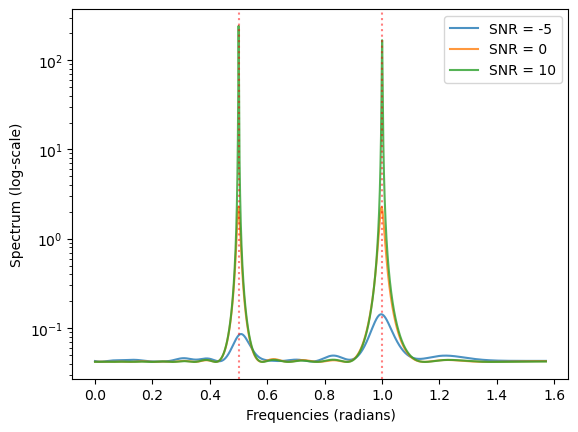

In [6]:
spectrums = [music(sampled_received, n_sources, aligned_mics_coords, main_frequency)
             for sampled_received in samples_diff_var]

X = np.linspace(0, np.pi/2, 10000)
Y = [[spectrum(x) for x in X] for spectrum in spectrums]

for i, y in enumerate(Y):
    plt.plot(X, y, label=f'SNR = {snr_values[i]}', alpha=0.8)
plt.legend()
plt.xlabel('Frequencies (radians)')
plt.ylabel('Spectrum (log-scale)')
plt.yscale('log')
#plt.title('Spectrum for multiple SNR (db)')
for theta in thetas:
    plt.axvline(x=theta, color='red', linestyle=':', alpha=0.5)
#plt.savefig('Figures/music_for_snr.png')
plt.show()

For SNR = -5, the MSE is 9.34E-03
For SNR = 0, the MSE is 1.76E-03
For SNR = 10, the MSE is 1.45E-04


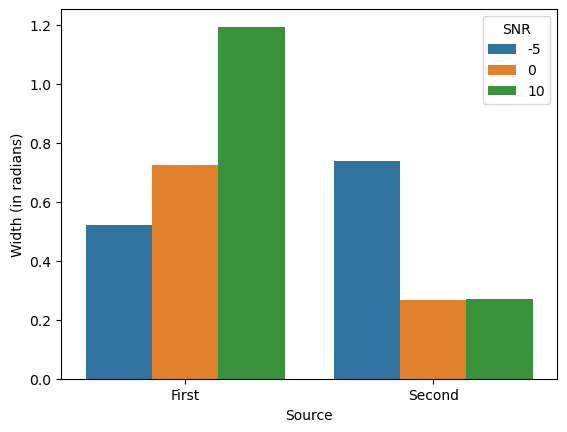

In [7]:
df = pd.DataFrame(columns = ['Width (in radians)', 'Source', 'SNR'])

for i, spectrum in enumerate(spectrums):
    estimated_thetas, indices = extract_frequencies(spectrum, n_sources, [0, np.pi / 2], return_peak_indices=True)
    print(f'For SNR = {snr_values[i]}, the MSE is {np.sqrt(np.sum((sorted(estimated_thetas)-thetas)**2)):.2E}')

    width, height, start, end = peak_widths(Y[i], indices, rel_height=1)
    sorted_indices = np.argsort(start)
    width = width[sorted_indices]
    df.loc[len(df)] = [width[0]/len(Y[i])*np.pi/2, 'First', snr_values[i]]
    df.loc[len(df)] = [width[1]/len(Y[i])*np.pi/2, 'Second', snr_values[i]]

sns.barplot(df, x="Source", y="Width (in radians)", hue="SNR")
#plt.title('Width of peak for different SNR values')
#plt.savefig('Figures/peak_width_for_snr.png')
plt.show()

# Plot for narrowband benchmark

In [8]:
narrowband_signals = [narrowband_signal(k, w0) for k in range(n_sources)]
received_signals = [received_signal(thetas, narrowband_signals, 
                                    mic_index=m+1, 
                                    main_frequency=main_frequency,
                                    mic_distance=mic_distance, 
                                    noise_var=0.1) for m in range(n_mics)]

n_samples = 1000

sampled_received = np.zeros((len(received_signals), n_samples), dtype=np.csingle)

for i, received in enumerate(received_signals):
    for j in range(n_samples):
        sampled_received[i, j] = received(j / fs)

sampled_received.shape

(24, 1000)

Samples shape: (24, 1000)
Covariance shape: (24, 24)
Shape of sources STFT: (1, 3, 24)
STFD shape: (24, 24)
Shape of noise eigenvectors: (24, 22)


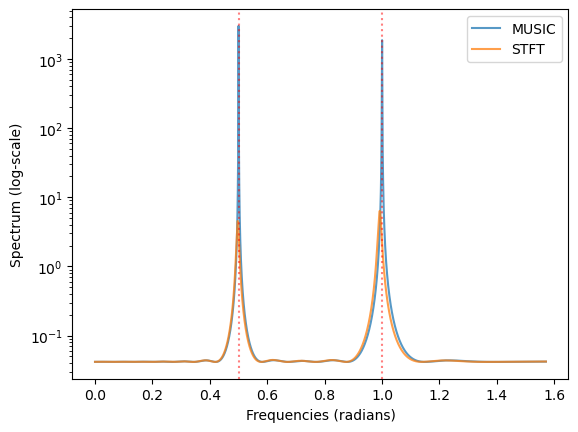

In [9]:
length = 1 # 20 for the other plot


spectrum = music(sampled_received, n_sources, aligned_mics_coords, main_frequency)
spectrum_stft = music_with_frequency(sampled_received, n_sources, fs, aligned_mics_coords, segment_duration=None,
                                     freq_range=[-main_frequency-length, -main_frequency+length])

X = np.linspace(0, np.pi/2, 10000)
Y_classic = [spectrum(x) for x in X]
Y_stft = [spectrum_stft(x) for x in X]

plt.plot(X, Y_classic, alpha=0.75, label='MUSIC')
plt.plot(X, Y_stft, alpha=0.75, label='STFT')
plt.legend()
plt.xlabel('Frequencies (radians)')
plt.ylabel('Spectrum (log-scale)')
plt.yscale('log')
for theta in thetas:
    plt.axvline(x=theta, color='red', linestyle=':', alpha=0.5)
#plt.savefig('Figures/narrowband_music_stft.png')
plt.show()

# Plot for broadband benchmark + runtime

In [10]:
def get_spectrums(data, mics_coords, real_freq_range, fs, main_frequency=600):
    spectrum_music = music(data, 1, mics_coords, main_frequency, verbose=False)
    spectrum_stft = music_with_frequency(data, 1, fs, mics_coords, None, real_freq_range, verbose=False)
    spectrum_hilbert = music(hilbert(data).conj(), 1, mics_coords, main_frequency, verbose=False)
    return [spectrum_music, spectrum_stft, spectrum_hilbert]

In [11]:
def get_Ys(spectra, freq_range, algorithms, resolution=10000, plot=True):
    X = np.linspace(freq_range[0], freq_range[1], resolution)
    Y = [[spectrum_function(x) for x in X] for spectrum_function in spectra]
    
    if plot:
        for i in range(len(algorithms)):
            plt.plot(X, Y[i], label=algorithms[i])

        plt.yscale('log')
        plt.xlabel('Frequencies (in radians)')
        plt.ylabel('Spectrum (log-scale)')
        plt.legend()
        plt.axvline(x=azimuth, color='red', linestyle=':', alpha=0.5)
        #plt.savefig('Figures/spectrum_all_algorithms.png')
        plt.show()
        
    return Y

In [12]:
import json   
with open('../music_doa/last_year/protocol.json') as json_file:  
    protocol = json.load(json_file)
    
microphone_3D_locations = np.array(protocol['geometry']['microphones']['locations'])
top_mics = np.isclose(microphone_3D_locations[:,2], 0.06123724)
microphone_2D_locations = microphone_3D_locations[top_mics, :2]

room_dim = np.r_[10.,10.]
mics_coords = (microphone_2D_locations + room_dim / 2).T

In [13]:
fs, data = wavfile.read('last_year/fq_sample3_spkr0_angle70.wav')
data = data[:, top_mics].T
real_freq_range = [0, 1800]
azimuth = np.array([70]) / 180. * np.pi # should be adapted based on "angleXX" in file name

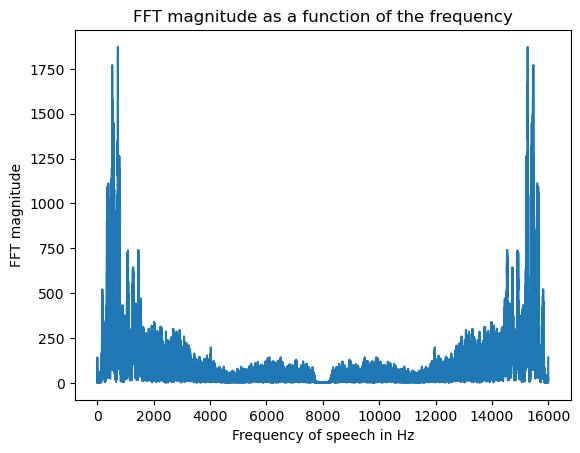

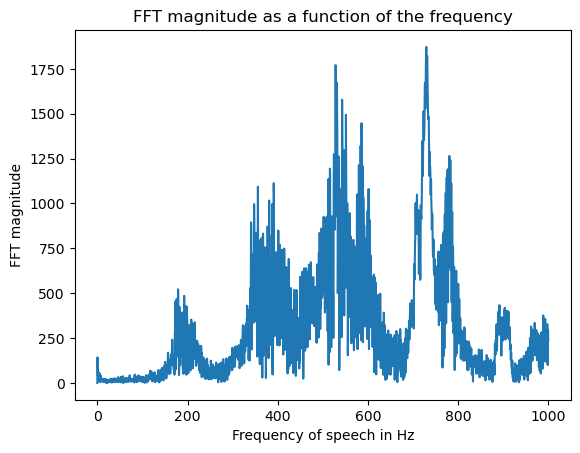

In [14]:
normalized_data = (data[0] - np.mean(data[0])) / np.std(data[0])

fft = np.fft.fft(normalized_data)
frequencies = np.linspace(0, fs, len(fft))

plt.plot(frequencies, abs(fft))
plt.xlabel("Frequency of speech in Hz")
plt.ylabel("FFT magnitude")
plt.title('FFT magnitude as a function of the frequency')
plt.show()

selected_ids = np.argwhere(frequencies < 1000)
selected_freq = frequencies[selected_ids]
selected_fft = fft[selected_ids]

plt.plot(selected_freq, abs(selected_fft))
plt.xlabel("Frequency of speech in Hz")
plt.ylabel("FFT magnitude")
plt.title('FFT magnitude as a function of the frequency')
plt.show()

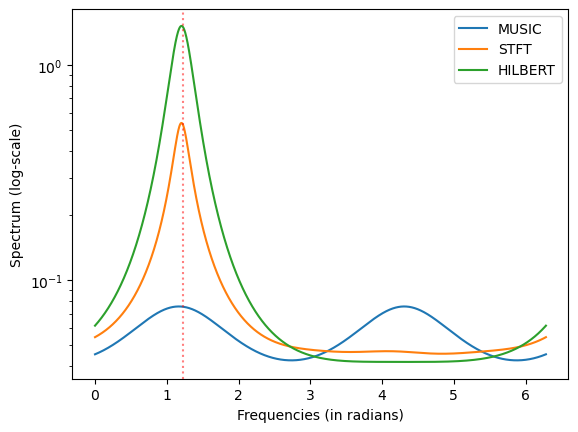

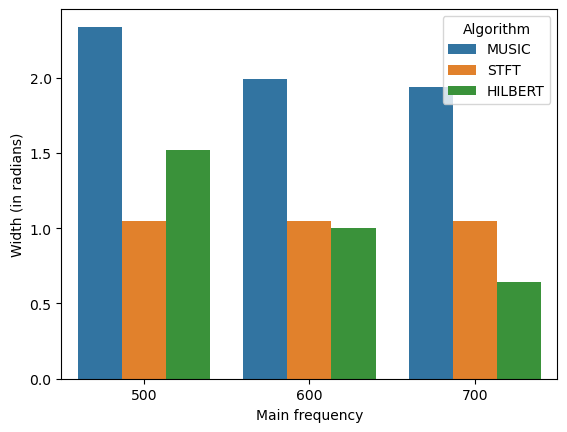

In [15]:
algorithms = ['MUSIC', 'STFT', 'HILBERT']
df = pd.DataFrame(columns = ['Width (in radians)', 'Main frequency', 'Algorithm'])
    
main_frequencies = [500, 600, 700]
for main_freq in main_frequencies:
    spectrums = get_spectrums(data, mics_coords, real_freq_range, fs, main_frequency=main_freq)
    plot = main_freq == 600
    Y = get_Ys(spectrums, (0, np.pi*2), algorithms, plot=plot)
    
    for i, spectrum in enumerate(spectrums):
        estimated_thetas, indices = extract_frequencies(spectrum, 1, [0, 2*np.pi], return_peak_indices=True)
        width, _, _, end = peak_widths(Y[i], indices, rel_height=0.9)

        df.loc[len(df)] = [width[0]/len(Y[i])*np.pi*2, main_freq, algorithms[i]]
    
sns.barplot(df, x='Main frequency', y="Width (in radians)", hue="Algorithm")
#plt.savefig('Figures/peak_width_for_algorithms.png')
plt.show()

# Plot for correlated sources

In [16]:
def get_samples_correlated_sources(mic_distance, thetas, wavelength, n_mics, n_sources, n_samples, noise_var):
    phis = np.array([np.exp(-2j * np.pi * mic_distance * np.sin(theta) / wavelength) for theta in thetas])
    A = np.vander(phis, n_mics, increasing=True).T
    
    S = np.zeros((n_sources, n_samples))
    
    S[0] = np.random.normal(0, 1, (1, n_samples))
    S[2] = np.random.normal(0, 1, (1, n_samples))
    S[1] = 0.5*S[0]+2*S[2]
    S[3] = np.random.normal(0, 1, (1, n_samples))
    
    noise_matrix = np.random.normal(0, noise_var, (n_mics, n_samples, 2)).view(np.complex128)\
                                        .reshape((n_mics, n_samples))
    return (A @ S) + noise_matrix

In [17]:
thetas = [0.2, 0.5, 1, 1.4]
n_sources = len(thetas)
n_samples = 10000

corr_samples = get_samples_correlated_sources(mic_distance, thetas, wavelength, n_mics,\
                                              n_sources, n_samples, noise_var=1)
names = ['MUSIC', 'Spatial smoothed MUSIC']

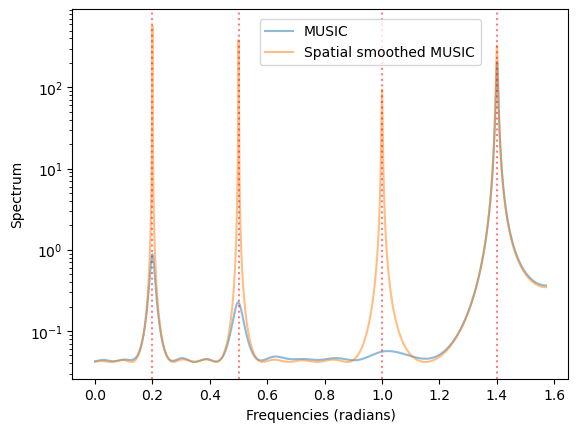

In [18]:
spectrums = [music(corr_samples, n_sources, aligned_mics_coords, main_frequency, verbose=False),
            music(corr_samples, n_sources, aligned_mics_coords, main_frequency, correlated=True, verbose=False)]

X = np.linspace(0, np.pi/2, 10000)
Y = [[spectrum(x) for x in X] for spectrum in spectrums]

for i, y in enumerate(Y):
    plt.plot(X, y, label=names[i], alpha=0.5)
plt.legend(bbox_to_anchor=(0.6, 0.83))
plt.xlabel('Frequencies (radians)')
plt.ylabel('Spectrum')
plt.yscale('log')
#plt.title('Spectrum with correlated sources')
for theta in thetas:
    plt.axvline(x=theta, color='red', linestyle=':', alpha=0.5)
#plt.savefig('Figures/spatial_smoothed_vs_music.png')
plt.show()

In [19]:
for spectrum in spectrums:
    estimated_thetas = extract_frequencies(spectrum, n_sources, [0, np.pi / 2])
    print('estimated thetas:', sorted(estimated_thetas), 'for number of sources =', n_sources)
print('actual thetas:   ', thetas)

estimated thetas: [0.19964821313563133, 0.49841367449202073, 1.4003649253376502] for number of sources = 4
estimated thetas: [0.19996237240099032, 0.49982739118613606, 0.9996547823722721, 1.4000507660722912] for number of sources = 4
actual thetas:    [0.2, 0.5, 1, 1.4]


# Plot for neural network TODO + runtime plots